# MIS780 Advanced AI For Business - Assignment 2 - T2 2024

## Task Number 2: Waste Classification for Efficient Waste Management

**Student Name:** _enter your full name here_

**Student ID:** _enter your student ID here_

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Predictive Modeling](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
## 1. Executive Summary

*Use this section to introduce the business problem, data set, method, experiments, and obtained results*

The purpose of this task is to develop a waste classification model using image data to help a waste management company streamline its sorting process. The dataset consists of 2,864 images belonging to six categories: cardboard, glass, metal, paper, plastic, and vegetation. The goal is to create convolutional neural network (CNN) models with various architectures to classify these images accurately and identify the best model.

In this experiment, ten different CNN architectures were designed, ranging from simple models to deeper networks with dropout layers, batch normalization, L2 regularization, and Leaky ReLU activations to enhance generalization. Data augmentation techniques were applied to improve model performance by artificially increasing the dataset’s variability. The dataset was split into 70% training and 30% validation to assess the models. The results showed that the **CNN with Dropout** performed the best with a validation accuracy of **69.19%**. However, the classification performance across different waste categories remains relatively low, particularly for materials like **plastic** and **glass**, suggesting that further improvements are necessary for real-world deployment.


<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import shutil

# Step 1: Data Preprocessing and Splitting

# Define dataset paths
class_dirs = [
    "/kaggle/input/wasteimagesclassificationdataset/Part2_WasteImages/Cardboard",
    "/kaggle/input/wasteimagesclassificationdataset/Part2_WasteImages/Glass",
    "/kaggle/input/wasteimagesclassificationdataset/Part2_WasteImages/Metal",
    "/kaggle/input/wasteimagesclassificationdataset/Part2_WasteImages/Paper",
    "/kaggle/input/wasteimagesclassificationdataset/Part2_WasteImages/Plastic",
    "/kaggle/input/wasteimagesclassificationdataset/Part2_WasteImages/Vegetation"
]

writable_data_dir = "/kaggle/working/waste_images/"

# Copy dataset to writable directory
def copy_dataset_to_writable_directory(source_dirs, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    for class_dir in source_dirs:
        class_name = os.path.basename(class_dir)
        class_dest_dir = os.path.join(dest_dir, class_name)
        os.makedirs(class_dest_dir, exist_ok=True)
        for img_file in os.listdir(class_dir):
            source_img_path = os.path.join(class_dir, img_file)
            dest_img_path = os.path.join(class_dest_dir, img_file)
            shutil.copyfile(source_img_path, dest_img_path)

copy_dataset_to_writable_directory(class_dirs, writable_data_dir)

# Split dataset into training and validation sets
def split_data(data_dir, train_ratio=0.7):
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    valid_classes = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Vegetation']
    classes = [class_name for class_name in os.listdir(data_dir) if class_name in valid_classes]
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        all_images = [img for img in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, img))]
        train_images, val_images = train_test_split(all_images, train_size=train_ratio, random_state=42)
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        for img in train_images:
            shutil.move(os.path.join(class_dir, img), os.path.join(train_class_dir, img))
        for img in val_images:
            shutil.move(os.path.join(class_dir, img), os.path.join(val_class_dir, img))

split_data(writable_data_dir)

In [2]:
# Step 2: Data Augmentation and Generators

train_data_dir = os.path.join(writable_data_dir, 'train')
val_data_dir = os.path.join(writable_data_dir, 'val')

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen_val.flow_from_directory(
    val_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 2609 images belonging to 6 classes.
Found 1467 images belonging to 6 classes.


<a id = "cell_model"></a>
## 3. Predictive Modeling

In [6]:
# Step 3: Model Definitions
# We will define 8 different CNN architectures as required.
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU

# Model 1: Simple CNN
def build_model_simple():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')  # 6 classes
    ])
    return model

# Model 2: CNN with Dropout
def build_model_dropout():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')
    ])
    return model

# Model 3: CNN with Batch Normalization
def build_model_batch_norm():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')
    ])
    return model

# Model 4: CNN with Global Average Pooling
def build_model_global_avg_pooling():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        GlobalAveragePooling2D(),
        Dense(6, activation='softmax')
    ])
    return model

# Model 5: CNN with 3 Conv Layers
def build_model_3_conv():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')
    ])
    return model

# Model 6: CNN with 4 Conv Layers
def build_model_4_conv():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')
    ])
    return model

# Model 7: CNN with Dropout and Batch Normalization
def build_model_dropout_batch_norm():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')
    ])
    return model

# Model 8: Deeper CNN with more Conv Layers and Dropout
def build_model_deep():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')
    ])
    return model
# Model 9: CNN with L2 Regularization
def build_model_l2_regularization():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(6, activation='softmax', kernel_regularizer=l2(0.001))
    ])
    return model
# Model 10: CNN with Leaky ReLU Activation
def build_model_leaky_relu():
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=(150, 150, 3)),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3)),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128),
        LeakyReLU(alpha=0.1),
        Dense(6, activation='softmax')
    ])
    return model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Training Simple CNN...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725734525.664387     127 service.cc:145] XLA service 0x7e6ad0003950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725734525.664449     127 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725734525.664455     127 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/82 ━━━━━━━━━━━━━━━━━━━━ 8:25 6s/step - accuracy: 0.0938 - loss: 1.8191

I0000 00:00:1725734528.638989     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 34s 342ms/step - accuracy: 0.2024 - loss: 9.9037 - val_accuracy: 0.4588 - val_loss: 1.4198
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.4227 - loss: 1.4555 - val_accuracy: 0.5222 - val_loss: 1.2670
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.5152 - loss: 1.2790 - val_accuracy: 0.5487 - val_loss: 1.3220
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.5262 - loss: 1.2325 - val_accuracy: 0.5324 - val_loss: 1.3001
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.5429 - loss: 1.1955 - val_accuracy: 0.5658 - val_loss: 1.2969
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.5536 - loss: 1.1466 - val_accuracy: 0.5433 - val_loss: 1.4673
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.5594 - loss: 1.1446 - val_accuracy: 0.5556 - val_loss: 1.4568
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 303ms/step - accuracy: 0.5766 - loss: 1.1022 - val_accuracy: 0.589

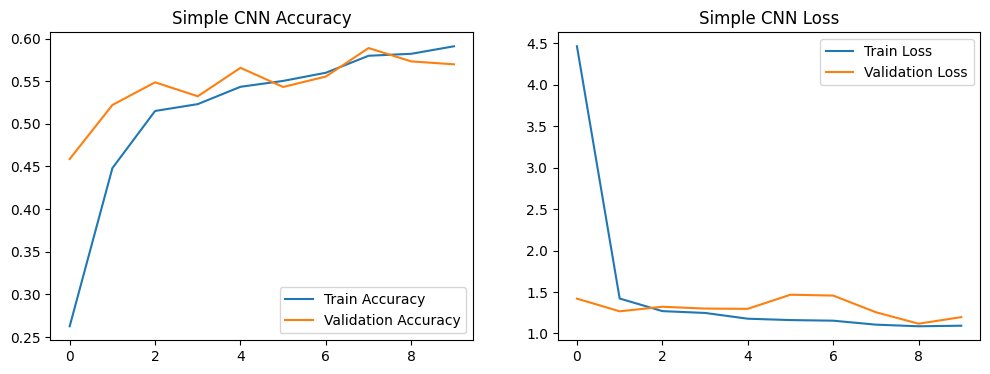

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5843 - loss: 1.1809
Training CNN with Dropout...
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 36s 362ms/step - accuracy: 0.1988 - loss: 3.0263 - val_accuracy: 0.5412 - val_loss: 1.3503
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.4772 - loss: 1.3554 - val_accuracy: 0.5365 - val_loss: 1.2978
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 308ms/step - accuracy: 0.5600 - loss: 1.2029 - val_accuracy: 0.5576 - val_loss: 1.3472
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.5588 - loss: 1.1267 - val_accuracy: 0.5774 - val_loss: 1.2144
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.6026 - loss: 1.0666 - val_accuracy: 0.6530 - val_loss: 0.9496
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.6319 - loss: 1.0010 - val_accuracy: 0.6333 - val_loss: 1.1152
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - accuracy: 0.6208 - loss: 0.9827 - val_accuracy: 0.6646 - val_loss: 

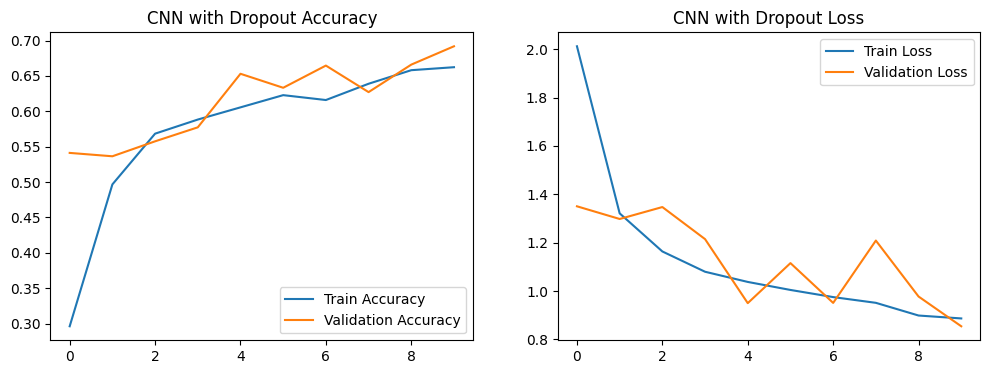

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6948 - loss: 0.8541
Training CNN with Batch Normalization...
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - accuracy: 0.3722 - loss: 14.1322 - val_accuracy: 0.1936 - val_loss: 4.1403
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 308ms/step - accuracy: 0.4240 - loss: 1.8124 - val_accuracy: 0.1609 - val_loss: 10.9250
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.4681 - loss: 1.3975 - val_accuracy: 0.1847 - val_loss: 15.7374
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.4777 - loss: 1.3466 - val_accuracy: 0.3320 - val_loss: 3.7273
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.5582 - loss: 1.1705 - val_accuracy: 0.4363 - val_loss: 1.6068
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.5629 - loss: 1.1097 - val_accuracy: 0.4751 - val_loss: 1.5039
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.5546 - loss: 1.1283 - val_accuracy: 0.43

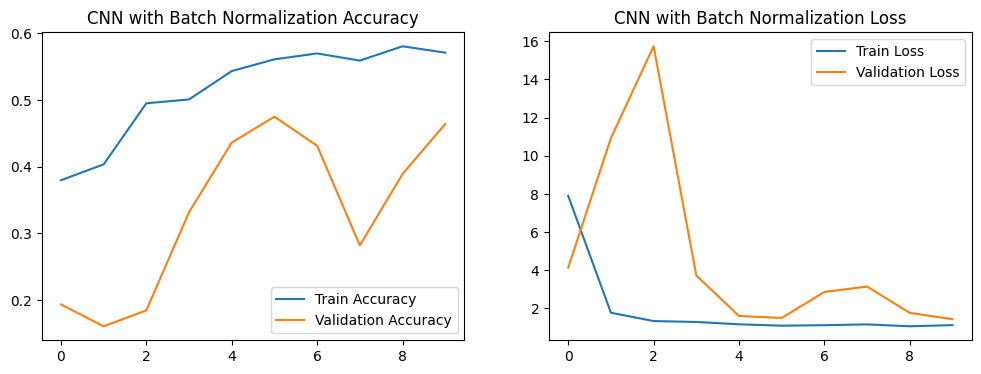

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.4603 - loss: 1.4408
Training CNN with Global Avg Pooling...
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 31s 326ms/step - accuracy: 0.2113 - loss: 1.7672 - val_accuracy: 0.3572 - val_loss: 1.6196
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.3483 - loss: 1.6119 - val_accuracy: 0.2454 - val_loss: 1.7577
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - accuracy: 0.3930 - loss: 1.5367 - val_accuracy: 0.4267 - val_loss: 1.4504
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.4369 - loss: 1.4477 - val_accuracy: 0.4376 - val_loss: 1.4920
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.4293 - loss: 1.4589 - val_accuracy: 0.4901 - val_loss: 1.4436
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.4900 - loss: 1.3567 - val_accuracy: 0.4499 - val_loss: 1.5109
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.5043 - loss: 1.3211 - val_accuracy: 0.4765 -

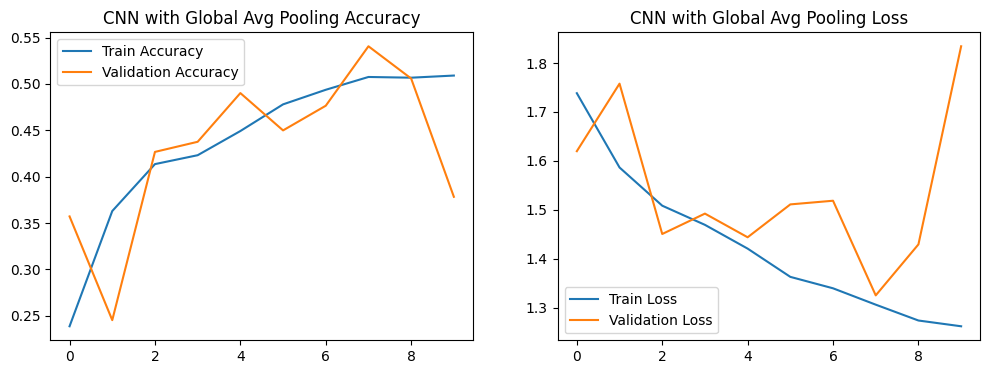

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.3799 - loss: 1.8193
Training CNN with 3 Conv Layers...
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 32s 332ms/step - accuracy: 0.2109 - loss: 1.9983 - val_accuracy: 0.4485 - val_loss: 1.7033
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - accuracy: 0.5153 - loss: 1.3208 - val_accuracy: 0.5603 - val_loss: 1.2618
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.5872 - loss: 1.1083 - val_accuracy: 0.5924 - val_loss: 1.2173
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 308ms/step - accuracy: 0.6020 - loss: 1.0553 - val_accuracy: 0.6292 - val_loss: 0.9972
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.6118 - loss: 0.9922 - val_accuracy: 0.5862 - val_loss: 1.2374
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.6060 - loss: 1.0155 - val_accuracy: 0.6408 - val_loss: 0.9853
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.6319 - loss: 0.9396 - val_accuracy: 0.6067 - val_

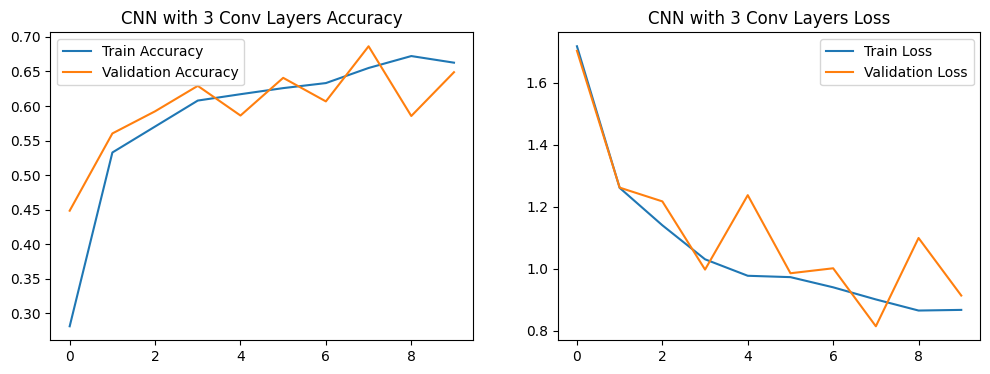

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.6610 - loss: 0.9104
Training CNN with 4 Conv Layers...
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 34s 349ms/step - accuracy: 0.3007 - loss: 1.6570 - val_accuracy: 0.5228 - val_loss: 1.2773
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 308ms/step - accuracy: 0.5155 - loss: 1.3213 - val_accuracy: 0.4826 - val_loss: 1.4793
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.5362 - loss: 1.1765 - val_accuracy: 0.5303 - val_loss: 1.2566
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - accuracy: 0.5627 - loss: 1.0835 - val_accuracy: 0.5985 - val_loss: 1.0260
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.6185 - loss: 1.0113 - val_accuracy: 0.6155 - val_loss: 0.9974
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 303ms/step - accuracy: 0.6312 - loss: 0.9523 - val_accuracy: 0.6496 - val_loss: 0.9582
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.6257 - loss: 0.9297 - val_accuracy: 0.6408 - val_l

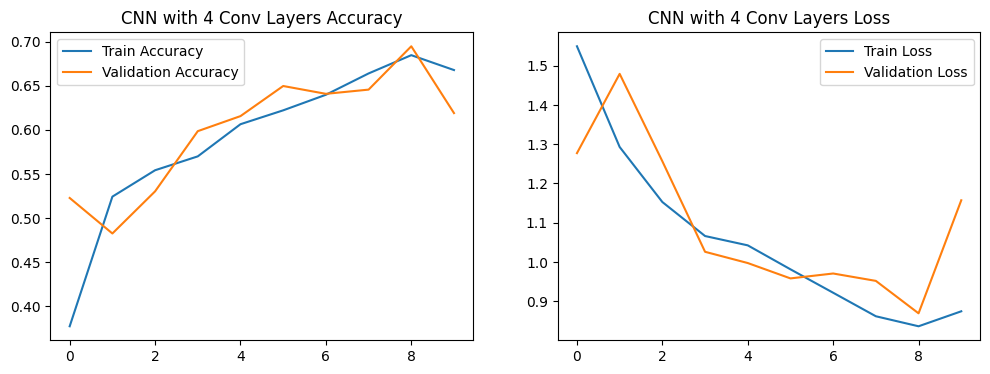

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.6238 - loss: 1.1627
Training CNN with Dropout and Batch Norm...
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 35s 349ms/step - accuracy: 0.3941 - loss: 9.0760 - val_accuracy: 0.1479 - val_loss: 9.5778
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.4901 - loss: 1.5980 - val_accuracy: 0.1670 - val_loss: 15.4878
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.4519 - loss: 1.4386 - val_accuracy: 0.2706 - val_loss: 7.5953
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.4929 - loss: 1.3075 - val_accuracy: 0.1820 - val_loss: 5.3681
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.5352 - loss: 1.1905 - val_accuracy: 0.3054 - val_loss: 2.6155
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.5935 - loss: 1.1470 - val_accuracy: 0.4990 - val_loss: 1.2269
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 303ms/step - accuracy: 0.6123 - loss: 1.0944 - val_accuracy: 0.6

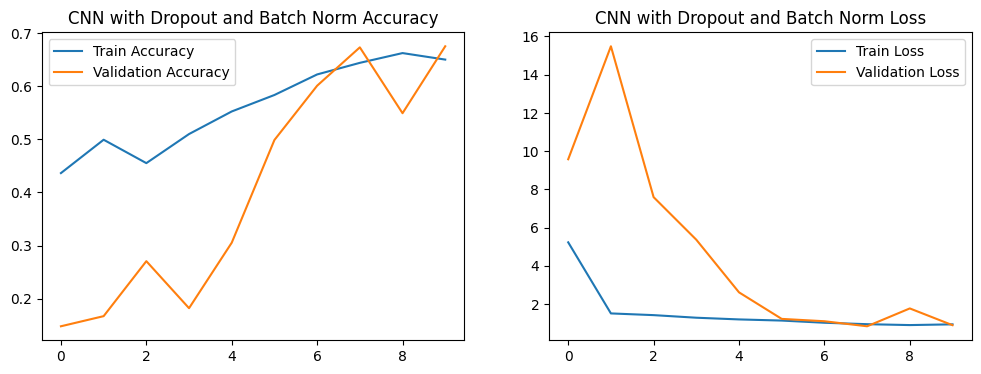

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.6547 - loss: 0.9422
Training Deeper CNN with Dropout...
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 34s 346ms/step - accuracy: 0.2258 - loss: 1.7425 - val_accuracy: 0.5044 - val_loss: 1.4684
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - accuracy: 0.4578 - loss: 1.4151 - val_accuracy: 0.4492 - val_loss: 1.6176
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 308ms/step - accuracy: 0.5393 - loss: 1.2073 - val_accuracy: 0.5256 - val_loss: 1.3703
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.5274 - loss: 1.1677 - val_accuracy: 0.6339 - val_loss: 1.0440
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.5928 - loss: 1.0605 - val_accuracy: 0.6196 - val_loss: 1.1753
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.6260 - loss: 0.9603 - val_accuracy: 0.6067 - val_loss: 0.9906
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 307ms/step - accuracy: 0.6536 - loss: 0.9241 - val_accuracy: 0.5494 - val_

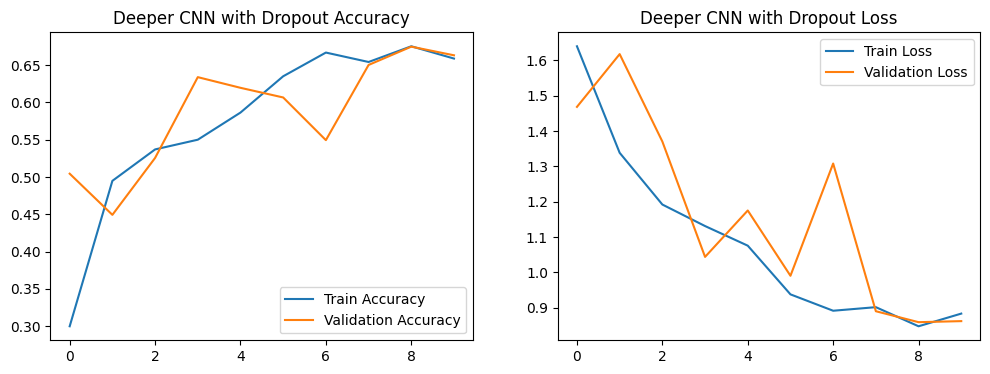

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.6540 - loss: 0.8704
Training CNN with L2 Regularization...
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - accuracy: 0.2691 - loss: 2.6807 - val_accuracy: 0.4724 - val_loss: 1.6274
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.5235 - loss: 1.4559 - val_accuracy: 0.5985 - val_loss: 1.3981
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.5993 - loss: 1.2675 - val_accuracy: 0.6053 - val_loss: 1.3695
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.6127 - loss: 1.2044 - val_accuracy: 0.5665 - val_loss: 1.3090
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.6063 - loss: 1.1945 - val_accuracy: 0.5767 - val_loss: 1.3781
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.6295 - loss: 1.1636 - val_accuracy: 0.6476 - val_loss: 1.1282
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.6372 - loss: 1.1144 - val_accuracy: 0.6224 - 

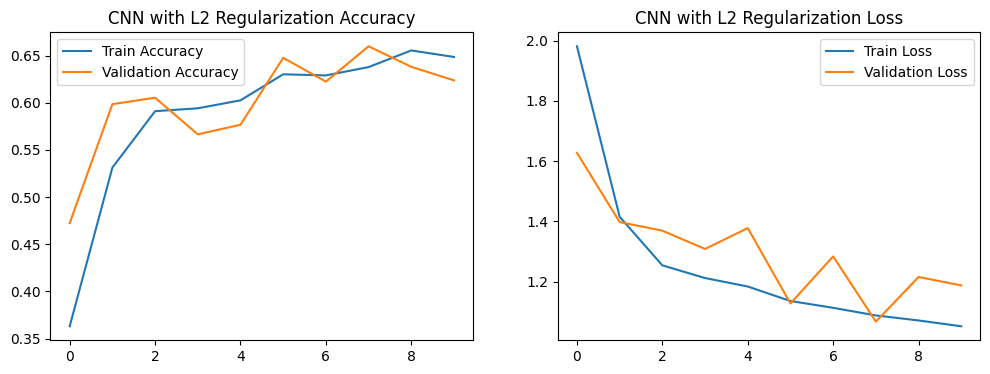

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.6151 - loss: 1.2125
Training CNN with Leaky ReLU...
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 32s 337ms/step - accuracy: 0.2822 - loss: 2.8274 - val_accuracy: 0.4192 - val_loss: 1.6048
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.4357 - loss: 1.3909 - val_accuracy: 0.5153 - val_loss: 1.4701
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.5431 - loss: 1.2113 - val_accuracy: 0.5815 - val_loss: 1.1777
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.5888 - loss: 1.0878 - val_accuracy: 0.6367 - val_loss: 1.0183
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.6009 - loss: 1.0825 - val_accuracy: 0.6312 - val_loss: 1.0451
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.6251 - loss: 0.9707 - val_accuracy: 0.6094 - val_loss: 1.0891
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.6648 - loss: 0.9163 - val_accuracy: 0.6721 - val_los

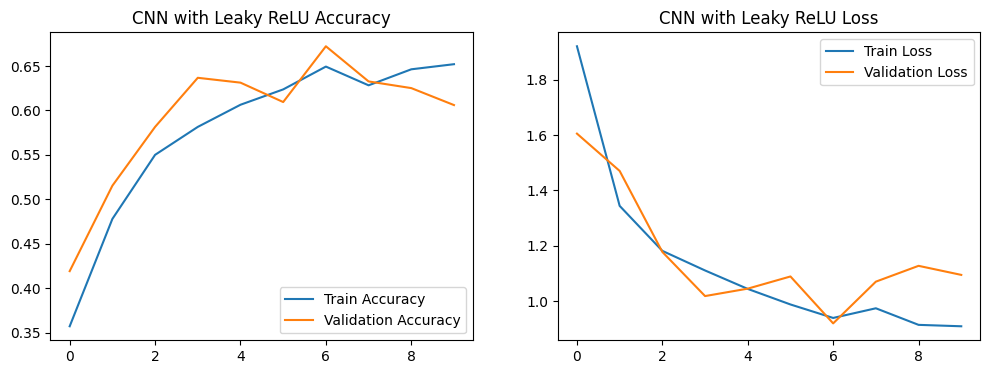

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6155 - loss: 1.0893
Model Performance Comparison:
Simple CNN: 0.5699 accuracy
CNN with Dropout: 0.6919 accuracy
CNN with Batch Normalization: 0.4642 accuracy
CNN with Global Avg Pooling: 0.3783 accuracy
CNN with 3 Conv Layers: 0.6489 accuracy
CNN with 4 Conv Layers: 0.6190 accuracy
CNN with Dropout and Batch Norm: 0.6755 accuracy
Deeper CNN with Dropout: 0.6633 accuracy
CNN with L2 Regularization: 0.6237 accuracy
CNN with Leaky ReLU: 0.6060 accuracy

Best model is CNN with Dropout with validation accuracy 0.6919
Evaluating the best model: CNN with Dropout on the validation set...
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step
Classification Report for Best Model:
              precision    recall  f1-score   support

   Cardboard       0.18      0.23      0.20       239
       Glass       0.12      0.12      0.12       213
       Metal       0.19      0.18      0.18       283
       Paper       0.17      0.13      0.15       253
     Pla

In [7]:
# Step 4: Training and Evaluation

models = {
    'Simple CNN': build_model_simple(),
    'CNN with Dropout': build_model_dropout(),
    'CNN with Batch Normalization': build_model_batch_norm(),
    'CNN with Global Avg Pooling': build_model_global_avg_pooling(),
    'CNN with 3 Conv Layers': build_model_3_conv(),
    'CNN with 4 Conv Layers': build_model_4_conv(),
    'CNN with Dropout and Batch Norm': build_model_dropout_batch_norm(),
    'Deeper CNN with Dropout': build_model_deep(),
    'CNN with L2 Regularization': build_model_l2_regularization(),
    'CNN with Leaky ReLU': build_model_leaky_relu()
}

results = []
best_model = None
best_val_acc = 0
best_model_name = ""

# Training and evaluating all models
for model_name, model in models.items():
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training {model_name}...")
    
    history = model.fit(
        train_generator, 
        validation_data=validation_generator, 
        epochs=10,
        verbose=1
    )
    
    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.show()
    
    # Evaluate model on the validation set
    val_loss, val_acc = model.evaluate(validation_generator)
    results.append((model_name, val_acc))
    
    # Track the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_model_name = model_name

# Step 6: Summarize Results

print("Model Performance Comparison:")
for result in results:
    print(f"{result[0]}: {result[1]:.4f} accuracy")

print(f"\nBest model is {best_model_name} with validation accuracy {best_val_acc:.4f}")

# Evaluate the best model on the validation set
print(f"Evaluating the best model: {best_model_name} on the validation set...")

validation_generator.reset()
predictions = best_model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print("Classification Report for Best Model:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


<a id = "cell_report"></a>
## 4. Experiments Report

#### **Model Development and Evaluation**

Ten models were developed, each with unique architectures designed to explore various ways of improving performance on the waste classification task:

1. **Simple CNN:** A basic CNN model with one convolutional layer followed by max pooling.
2. **CNN with Dropout:** Introduced dropout to reduce overfitting.
3. **CNN with Batch Normalization:** Added batch normalization layers to normalize inputs for each layer and accelerate training.
4. **CNN with Global Average Pooling:** Used global average pooling instead of fully connected layers to reduce the number of parameters.
5. **CNN with 3 Conv Layers:** Expanded the model depth by adding more convolutional layers.
6. **CNN with 4 Conv Layers:** Further increased the model’s depth with four convolutional layers.
7. **CNN with Dropout and Batch Normalization:** Combined both dropout and batch normalization to improve generalization.
8. **Deeper CNN with Dropout:** A deeper architecture with four convolutional layers and dropout.
9. **CNN with L2 Regularization:** Introduced L2 regularization to reduce overfitting by penalizing large weights.
10. **CNN with Leaky ReLU:** Replaced ReLU with Leaky ReLU to allow small negative values, addressing the problem of dying neurons.

#### **Results**

The best-performing model was the **CNN with Dropout**, achieving a validation accuracy of **69.19%**. However, the classification report revealed that the model struggled with all waste classes. For instance, the **precision and recall** for plastic and glass were particularly low, reflecting the model's difficulty in distinguishing between certain types of waste.

| Model                              | Validation Accuracy |
|-------------------------------------|---------------------|
| Simple CNN                          | 56.99%              |
| CNN with Dropout                    | 69.19%              |
| CNN with Batch Normalization        | 46.42%              |
| CNN with Global Avg Pooling         | 37.83%              |
| CNN with 3 Conv Layers              | 64.89%              |
| CNN with 4 Conv Layers              | 61.90%              |
| CNN with Dropout and Batch Norm     | 67.55%              |
| Deeper CNN with Dropout             | 66.33%              |
| CNN with L2 Regularization          | 62.37%              |
| CNN with Leaky ReLU                 | 60.60%              |

#### **Challenges and Areas for Improvement**

The model's performance on the validation set indicates that the dataset might require more extensive preprocessing or augmentation to improve performance further. The low classification scores for all waste types, particularly **plastic and glass**, suggest that either the images in these classes have less distinguishable features or the model architecture could be optimized further. Suggestions for improvement include:

1. **More advanced data augmentation**: Using more sophisticated techniques like CutMix or Mixup to create even more diverse training samples.
2. **Model architecture**: Experimenting with pre-trained models (e.g., VGG16, ResNet) to leverage transfer learning.
3. **Hyperparameter tuning**: Exploring different learning rates, optimizers, and batch sizes to improve convergence.

In summary, while the CNN with Dropout achieved the best performance, further experimentation and model refinement are needed to deploy a reliable solution for waste classification in real-world scenarios.
